In [ ]:
import os
import gc
import json
import torch
import datetime
import threading

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import concurrent.futures
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [16]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

In [ ]:
x = network_analytics['Timestamp'][:100]
y = network_analytics['OutboundUtilzation (%)'][:100]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(x, y, marker='o')

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')
ax.set_xlabel('Timestamp')

ax.grid(True, axis='y')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
[lab.set_rotation(30) for lab in ax.get_xticklabels()]

In [ ]:
print(network_analytics['Timestamp'].max())
print(network_analytics['Timestamp'].min())
print(datetime.datetime.strptime(network_analytics['Timestamp'][len(network_analytics) - 1], '%d/%m/%Y %H:%M') - datetime.datetime.strptime(network_analytics['Timestamp'][0], '%d/%m/%Y %H:%M'))

In [ ]:
network_analytics.describe()

In [ ]:
sns.displot(network_analytics['OutboundUtilzation (%)'], kde=True, bins=50)

In [ ]:
network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
network_analytics_new = network_analytics.set_index('Timestamp')
network_analytics_new.rename(columns={'OutboundUtilzation (%)':'traffic_out'},inplace=True)  

x = network_analytics_new.index
y = network_analytics_new['traffic_out']

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
network_analytics_1H = network_analytics_new.resample('1H').mean()

x = network_analytics_1H.index[1500:]
y = network_analytics_1H[1500:]

fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(x, y)

fig.suptitle('Interface traffic evolution')
ax.set_ylabel('OutboundUtilzation (%)')

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
pd.plotting.lag_plot(series)

In [ ]:
print(series.autocorr())

In [ ]:
pd.plotting.autocorrelation_plot(series)

In [ ]:
plot_acf(series, lags=60)
plt.ylabel("Autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

In [ ]:
plot_pacf(series, lags=60)
plt.ylabel("Partial autocorrelation value")
plt.xlabel("Lagged value")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(30,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

## Data preparation and utility function definition

In [57]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

In [58]:
def print_errors(usedlag, test, predictions):
    test = test[:-1]
    predictions = predictions[1:]
    rmse = sqrt(mean_squared_error(test, predictions))
    print(f"RMSE for {usedlag} lagged values: {rmse}")

    mape = mean_absolute_percentage_error(test, predictions)
    print(f"MAPE for {usedlag} lagged values: {mape}")

    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    print(f"SMAPE for {usedlag} lagged values: {smape}")

    mae = mean_absolute_error(test, predictions)
    print(f"MAE for {usedlag} lagged values: {mae}")

In [59]:
def plot_difference(test, predictions, dataset=network_analytics):
    test = test[:-1]
    predictions = predictions[1:]
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(dataset.index[-100:], test[len(test)- 100:], color='g', label='ground truth')
    ax.plot(dataset.index[-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
    plt.title('Difference between predicted and actual value')
    plt.xticks(dataset.index[-100::12])
    plt.legend(loc='best')
    plt.ylabel('OutboundUtilzation (%)')
    plt.xlabel('Timestamp')
    plt.show()

In [74]:
statistics, pval, ma_order, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {ma_order} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {ma_order} {nobs}")

Data is stationary -12.704162687630872 1.0639878489320223e-23 49 25581.


In [81]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

## MA model

In [ ]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = ARIMA(endog=train, order=(0, 0, id))
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

dir = 'output/information_criteria/MA'
for wrapp in range(6, 10):
    results = []
    with concurrent.futures.ThreadPoolExecutor(5) as executor:
        futures = {executor.submit(worker_func, (wrapp * 10) + x): x for x in range(1, 11)}
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())

    results = sorted(results, key=lambda x : x[0])

    with open(f"{dir}/MA_{wrapp}_criterions.json", 'w') as json_file:
        json.dump(results, json_file)

In [ ]:
dir = 'output/information_criteria/MA/'

data = []
for file in os.listdir(dir):
    full_file_name = dir + file
    with open(full_file_name, 'r') as json_file:
        new_data = json.load(json_file)
    data.extend([dato for dato in new_data])
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

print(len(data))

threshold = 0.05
selected_order = np.argmax(np.array(p_values) < threshold) +  1
print(selected_order)
# first_lag = np.where(p_values == 1)
# print(first_lag)
# print(first_lag[0][0])
min_lag = np.argmin(p_values)
print(min_lag)
print("P Values: ", p_values)
print("Selected Order (p):", selected_order)


plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [82]:
selected_order = ma_order
MA_model = ARIMA(endog=train, order=(0, 0, selected_order))
# if os.path.isfile('MA.pkl'):
#     results = ARIMAResults.load('MA.pkl')
# else:
results = MA_model.fit()

In [95]:
results.save('MA.pkl')

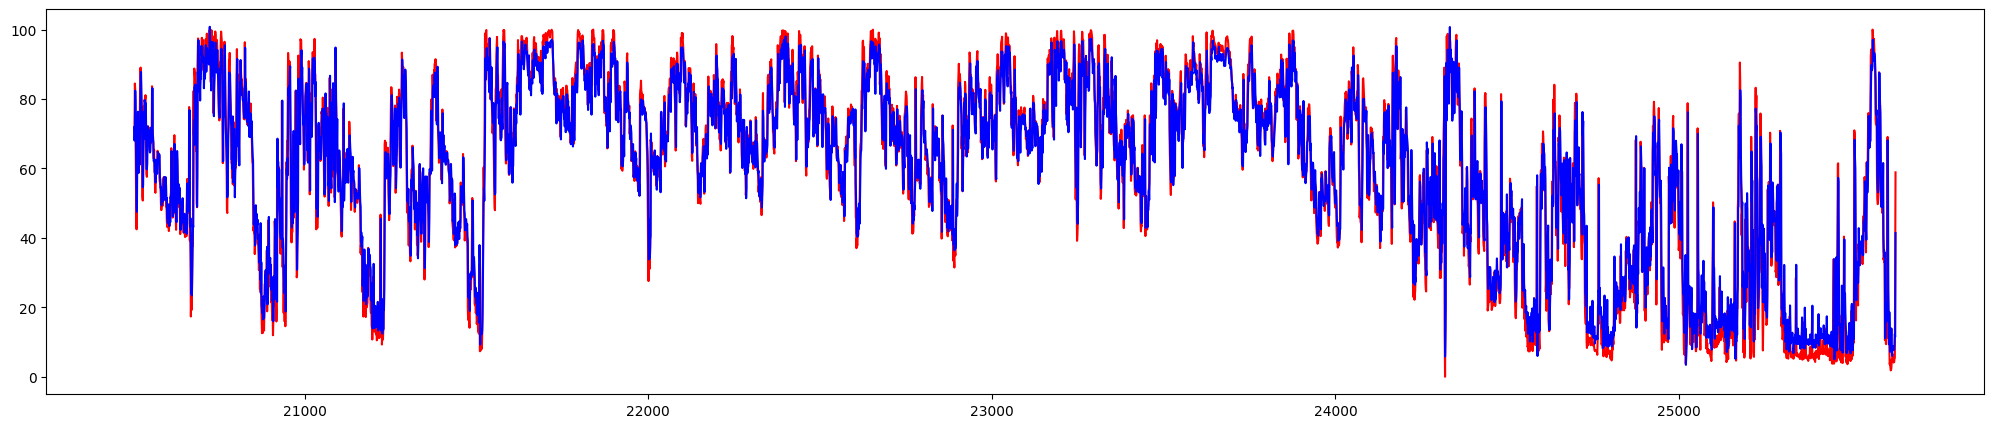

In [83]:
coef = results.params
# Grab last x values of the train dataset
history = train[len(train)-selected_order:]
# Compute their prediction
pred = results.predict(start=len(train) - selected_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history - pred).tolist()

predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(selected_order):
        yhat += coef[d+1] * errors[selected_order-d-1]
        obs = X[t]
    predictions.append(yhat)

    errors.pop(0)
    errors.append(X[len(train) + t] - yhat)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(range(size, len(network_analytics)),network_analytics['OutboundUtilzation (%)'][size:len(network_analytics)], color='r')
ax.plot(range(size, len(network_analytics)), predictions, color='b')

In [84]:
print_errors(ma_order, test, predictions)

RMSE for 49 lagged values: 3.0504804284403004
MAPE for 49 lagged values: 48.271201839494104
SMAPE for 49 lagged values: 7.932514000967918
MAE for 49 lagged values: 2.4213013235761043


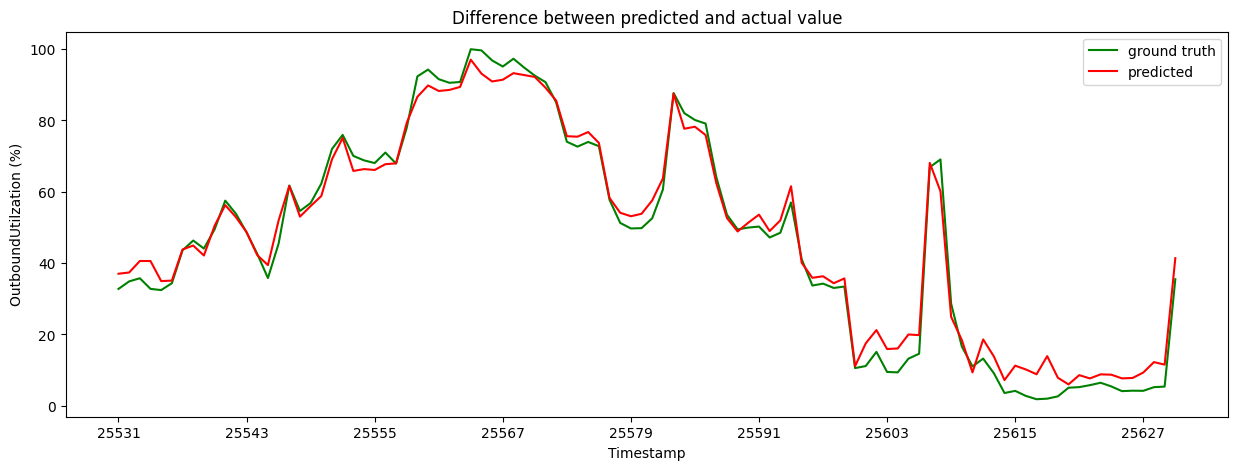

In [85]:
plot_difference(test, predictions)

## AR model

In [ ]:
def worker_func(id : int):
    if id % 10 == 0:
        print(f"Processing {id} by thread {threading.get_native_id()}")
    model = AutoReg(train, lags=id)
    result = model.fit()
    aic = result.aic
    bic = result.bic
    residuals = result.resid
    result = acorr_ljungbox(residuals, lags=[id])
    p_value = result.iloc[0,1]
    return id, aic, bic, p_value

dir = 'output/information_criteria/AR'
results = []
with concurrent.futures.ThreadPoolExecutor(5) as executor:
    futures = {executor.submit(worker_func, x): x for x in range(1, 500)}
    for future in concurrent.futures.as_completed(futures):
        results.append(future.result())

results = sorted(results, key=lambda x : x[0])

with open(f"{dir}/criterions.json", 'w') as json_file:
    json.dump(results, json_file)

Selected Order (p): 3


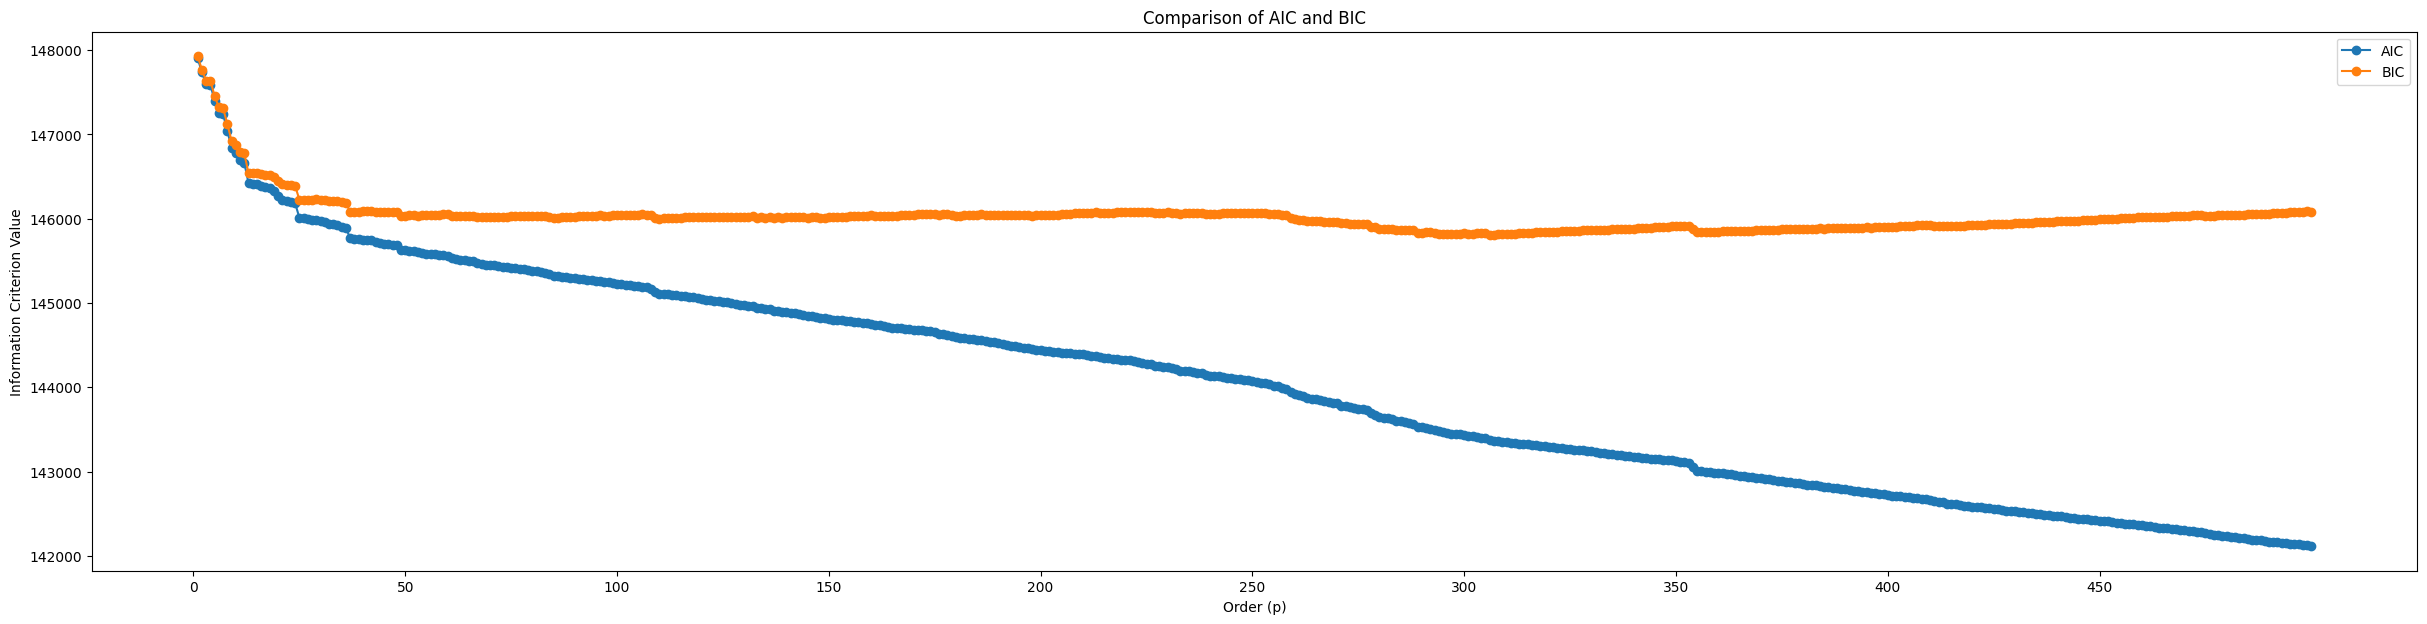

In [86]:
dir = 'output/information_criteria/AR'
with open(f"{dir}/criterion.json", 'r') as json_file:
    data = json.load(json_file)
data = sorted(data, key=lambda x : x[0])
data = np.array(data)
aic_values = data[:,1]
bic_values = data[:,2]
p_values = data[:,3]

threshold = 0.05
selected_order = np.argmax(np.array(p_values) > threshold) +  1

first_lag = np.where(p_values == 1)

min_lag = np.where(np.min(p_values))

print("Selected Order (p):", selected_order)

plt.figure(figsize=(30,7))
plt.plot(range(1, len(data) + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, len(data) + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Order (p)')
plt.ylabel('Information Criterion Value')
plt.title('Comparison of AIC and BIC')
plt.xticks(np.arange(0, len(data), 50.0))
plt.legend()
plt.show()

In [90]:
ar_order = selected_order # first_lag[0][0]

model = AutoReg(train, lags=ar_order)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-ar_order:].tolist()
predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]
        obs = X[t]
    predictions.append(yhat)
    history.pop(0)
    history.append(obs)

In [91]:
print_errors(ar_order, test, predictions)

RMSE for 3 lagged values: 34.02805370413802
MAPE for 3 lagged values: 109.58415213836338
SMAPE for 3 lagged values: 55.40744518853258
MAE for 3 lagged values: 27.746699768067835


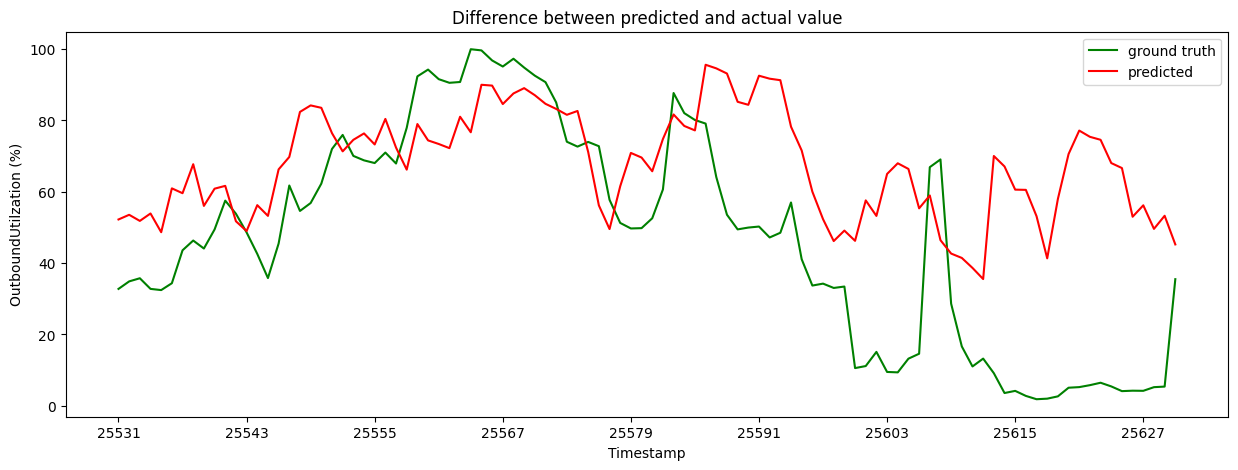

In [92]:
plot_difference(test, predictions)

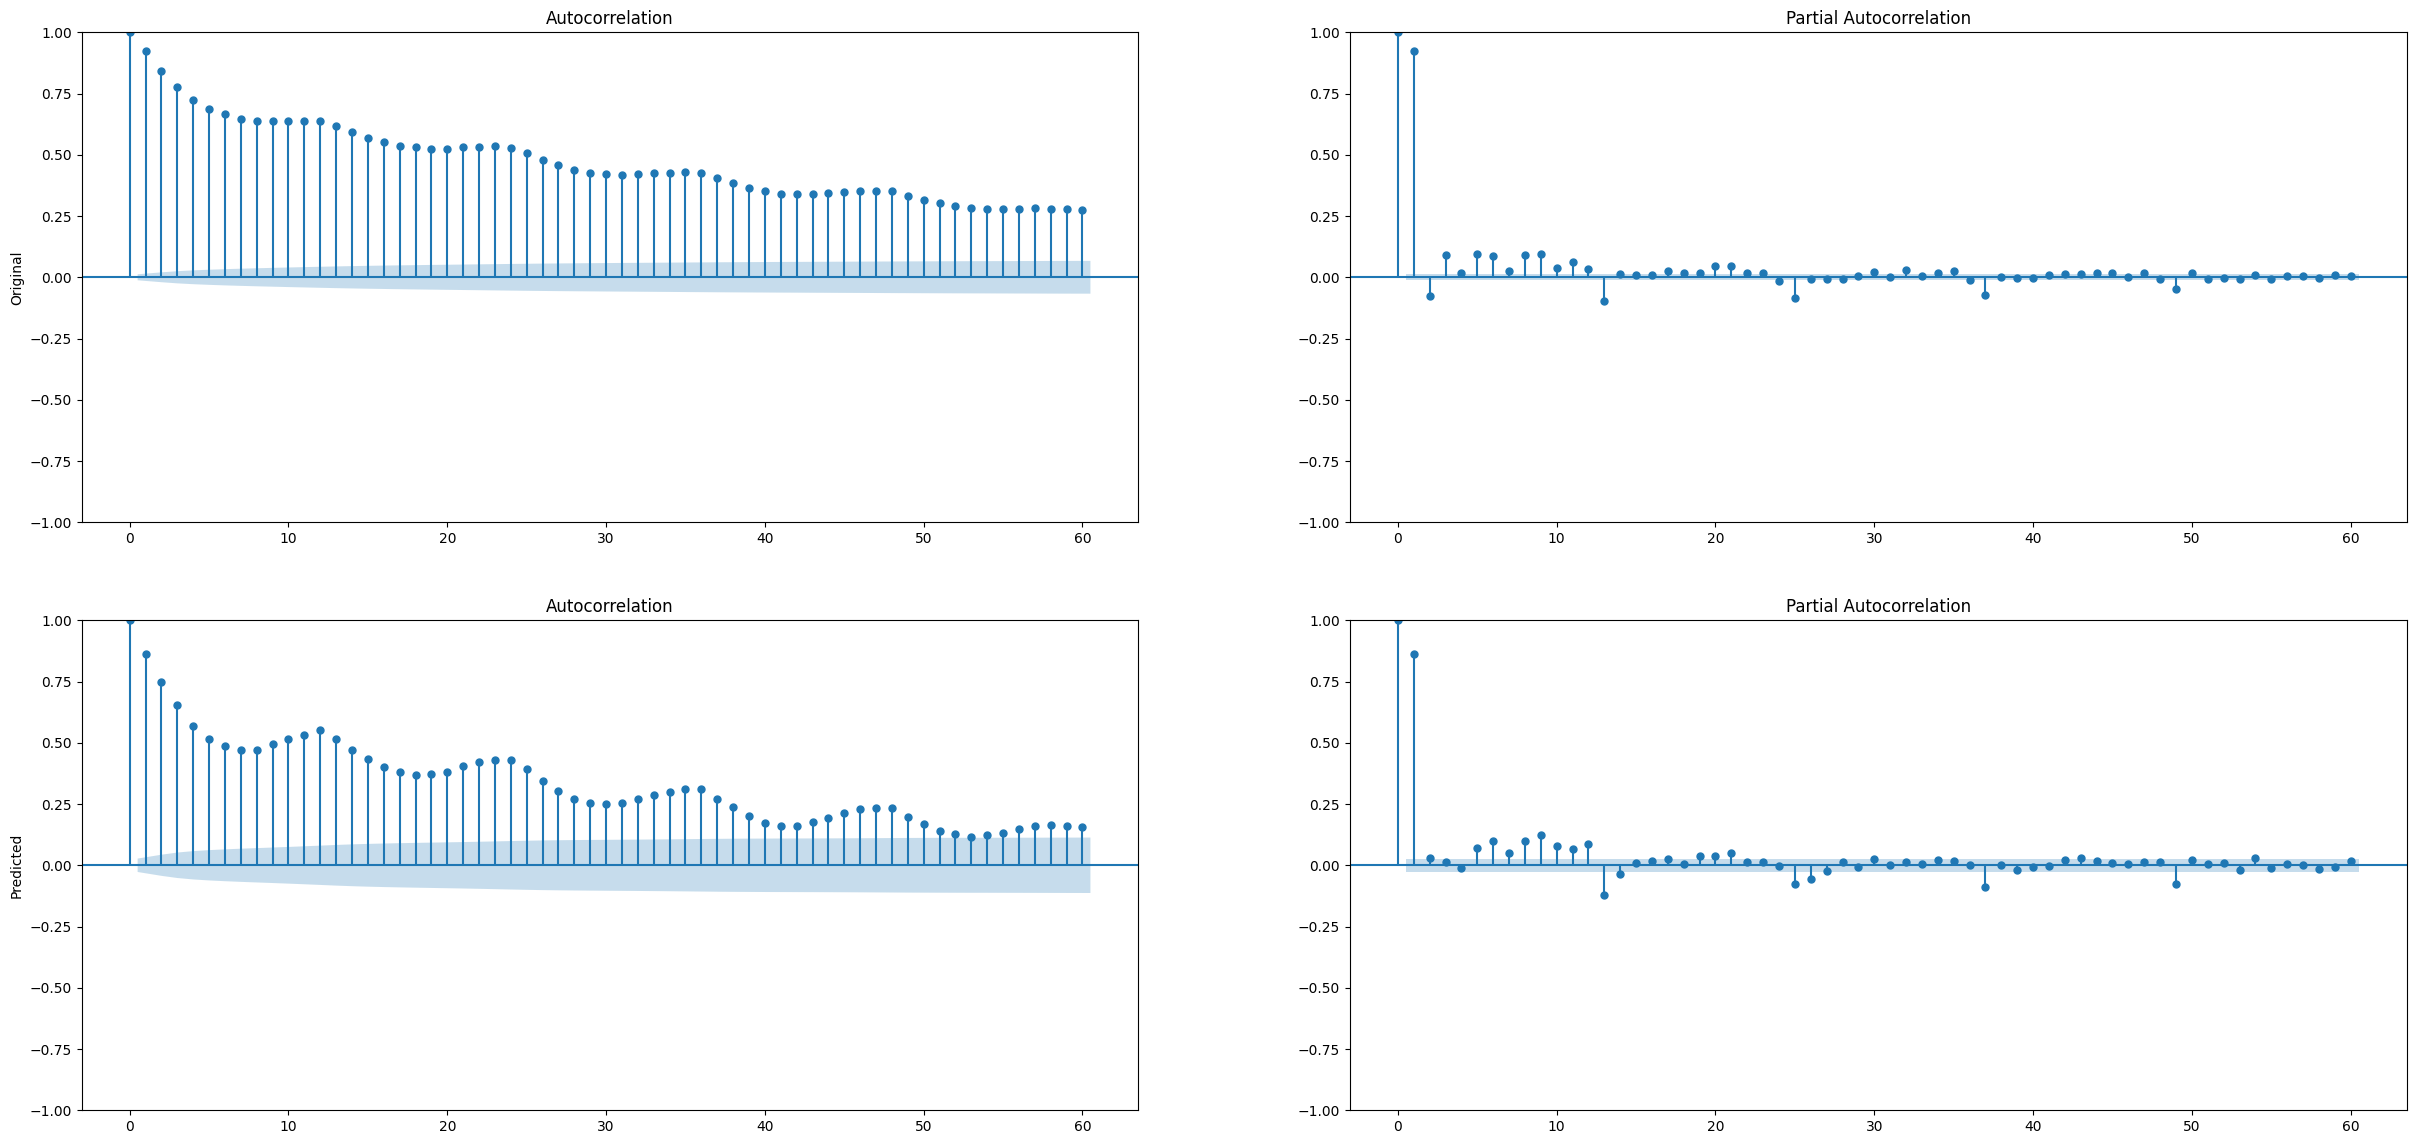

In [93]:
fig, ax = plt.subplots(2,2,figsize=(30,14))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0, 0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[0, 1])
sm.graphics.tsa.plot_acf(predictions, lags=60, ax=ax[1, 0])
sm.graphics.tsa.plot_pacf(predictions, lags=60, ax=ax[1, 1])
ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Predicted")
plt.show()

## ARIMA

In [ ]:
# network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
# network_analytics = network_analytics.set_index('Timestamp')
# network_analytics_2H = network_analytics.resample('2H').mean()
# series = pd.Series(network_analytics_2H['OutboundUtilzation (%)'].values)

X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [ ]:
model = ARIMA(train, order=(ar_order, 0, ma_order))
model_fit = model.fit()

In [ ]:
model_fit.save('ARIMA_new.pkl')

In [ ]:
coef = model_fit.params
history = train[len(train)-ar_order:].tolist()

history_ma = train[len(train)-ma_order:].tolist()
pred = model_fit.predict(start=len(train) - ma_order + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history_ma - pred).tolist()

predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(ar_order):
        yhat += coef[d+1] * history[d]

    for d in range(ma_order):
        yhat += coef[d+ar_order+1] * errors[ma_order-d-1]

    errors.pop(0)
    errors.append(test[t] - yhat)
    predictions.append(yhat)
    history.pop(0)
    history.append(test[t])

In [ ]:
print_errors(f"ARIMA({ar_order}, 0, {ma_order})", test, predictions)

In [ ]:
plot_difference(test, predictions)

## CNN

In [60]:
train_len = int(len(network_analytics) * 0.80)
valid_len = int(len(network_analytics) * 0.15)

train = network_analytics[:train_len]
valid = network_analytics[train_len:(train_len + valid_len)]
test = network_analytics[train_len + len(valid):]

assert len(network_analytics) == (len(train) + len(valid) + len(test))

print('Proportion of train_set : {:.2f}%'.format(len(train)/len(network_analytics) * 100))
print('Proportion of valid_set : {:.2f}%'.format(len(valid)/len(network_analytics) * 100))
print('Proportion of test_set : {:.2f}%'.format(len(test)/len(network_analytics) * 100))

Proportion of train_set : 80.00%
Proportion of valid_set : 15.00%
Proportion of test_set : 5.01%


In [61]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

raw_seq = [10,20,30,40,50,60,70,80,90]
n_steps = 3
train_x,train_y = split_sequence(train['OutboundUtilzation (%)'].values,n_steps)
valid_x,valid_y = split_sequence(valid['OutboundUtilzation (%)'].values,n_steps)
test_x,test_y = split_sequence(test['OutboundUtilzation (%)'].values,n_steps)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class NetworkAnalyticsDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item, label
    
# https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8489399
class TimeseriesCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(TimeseriesCNN,self).__init__()

        self.conv1 = nn.Conv1d(3, 48, kernel_size=1)
        self.conv2 = nn.Conv1d(48, 96, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(96, 20)
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = x.view(-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [62]:
model = TimeseriesCNN().to(device)
model.load_state_dict(torch.load('model200.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [63]:
train = NetworkAnalyticsDataset(train_x.reshape(train_x.shape[0],train_x.shape[1], 1), train_y)
valid = NetworkAnalyticsDataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1], 1), valid_y)
test = NetworkAnalyticsDataset(test_x.reshape(test_x.shape[0],test_x.shape[1], 1), test_y)

train_loader = DataLoader(train, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid, batch_size=1, shuffle=False)
test_loader = DataLoader(test, batch_size=1, shuffle=False)

In [64]:
def train(loader : DataLoader):  
    running_loss = .0
    model.train()
    
    for idx, (inputs,labels) in enumerate(loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(loader)
    return train_loss.detach().cpu().numpy()
    
def validate(loader : DataLoader):
    running_loss = .0
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(loader)
        return valid_loss.detach().cpu().numpy()

def test(model, loader : DataLoader):
    running_loss = .0
    model.eval()
    predicted = []
    actuals = []
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            predicted.extend(preds.detach().cpu().numpy())
            actuals.extend(labels.detach().cpu().numpy())
            
        test_loss = running_loss/len(loader)
        return test_loss.detach().cpu().numpy(), np.array(predicted), np.array(actuals)

In [ ]:
epochs = 200

train_losses = []
valid_losses = []

for epoch in tqdm(range(epochs)):
    train_losses.append(train(train_loader))
    valid_losses.append(validate(valid_loader))
    gc.collect()

In [ ]:
plt.figure(figsize=(30,7))
plt.title('Loss evolution')
plt.plot(train_losses, marker='x', color='r', label='train loss')
plt.plot(valid_losses, marker='x', color='b', label='valid loss')
plt.show()
plt.legend(loc='best')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [65]:
model = TimeseriesCNN().to(device)
model.load_state_dict(torch.load("model200.pt"))
model.eval()


loss, predictions, actuals = test(model, test_loader)
print_errors(f"CNN", actuals, predictions)

RMSE for CNN lagged values: 4.171446131689805
MAPE for CNN lagged values: 0.33221474289894104
SMAPE for CNN lagged values: 24.455551135530687
MAE for CNN lagged values: 3.7281014919281006


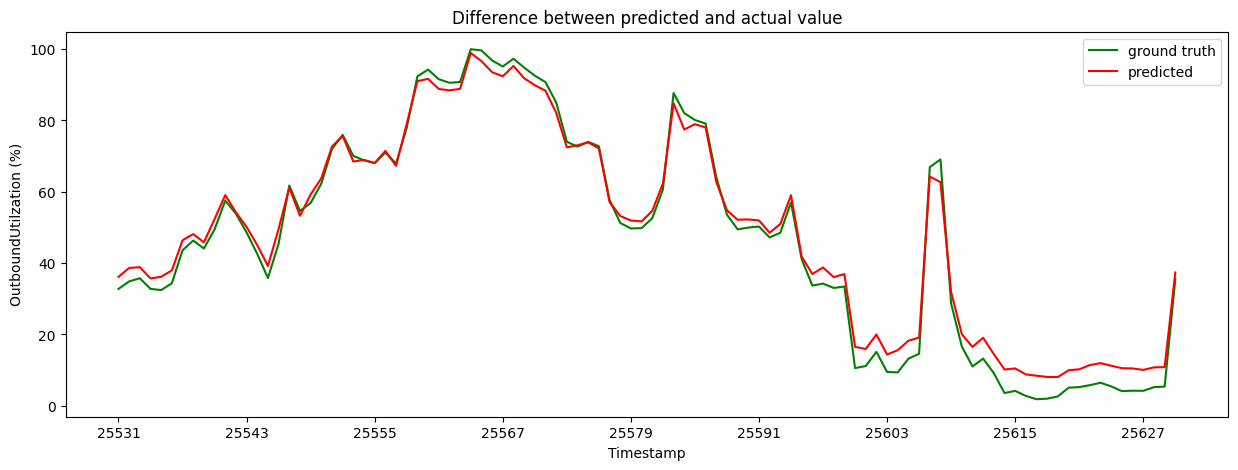

In [66]:
plot_difference(actuals, predictions)

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x : torch.Tensor):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).to(device), torch.tensor(y).to(device)

In [69]:
df = pd.read_csv('./data/Network_Analytics.csv')
timeseries = df[["OutboundUtilzation (%)"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.80)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [70]:
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1

X_train, y_train = create_dataset(train, lookback=hidden_size)
X_test, y_test = create_dataset(test, lookback=hidden_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([20454, 50, 1]) torch.Size([20454, 50, 1])
torch.Size([5077, 50, 1]) torch.Size([5077, 50, 1])


In [ ]:
learning_rate = 0.00001
num_epochs = 1000

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from copy import deepcopy

best_loss = np.inf
best_model = None

loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

for epoch in range(num_epochs):
    model.train()
    for x, y in loader:
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred, y_train).detach().cpu())
        y_pred = model(X_test)
        test_rmse = np.sqrt(criterion(y_pred, y_test).detach().cpu())     

        if test_rmse < best_loss:
            print("Epoch %d: best RMSE %.4f, new RMSE %.4f" % (epoch, best_loss, test_rmse))
            best_loss = test_rmse
            best_model = deepcopy(model)


In [71]:
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load("best_lstm.pt"))
model.eval()
y_pred = model(X_test).detach().cpu().numpy()
y_pred = y_pred[:, -1, :]
y_values = y_test.detach().cpu().numpy()[:, -1, :]

In [72]:
print_errors(f"LSTM", y_values, y_pred)

RMSE for LSTM lagged values: 3.233538828215406
MAPE for LSTM lagged values: 36.183197021484375
SMAPE for LSTM lagged values: 7.2702201921419425
MAE for LSTM lagged values: 2.2763991355895996


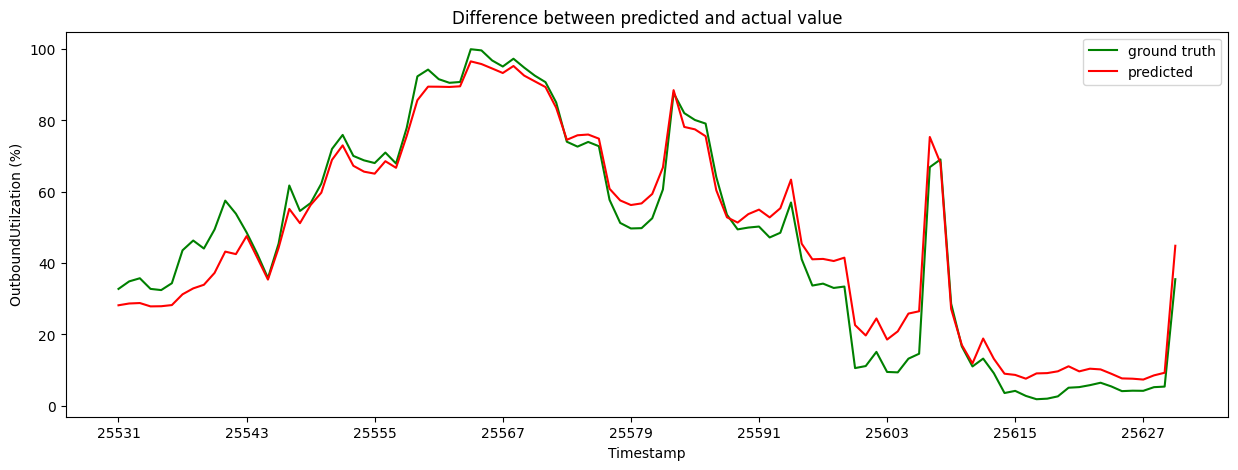

In [73]:
plot_difference(y_values, y_pred)